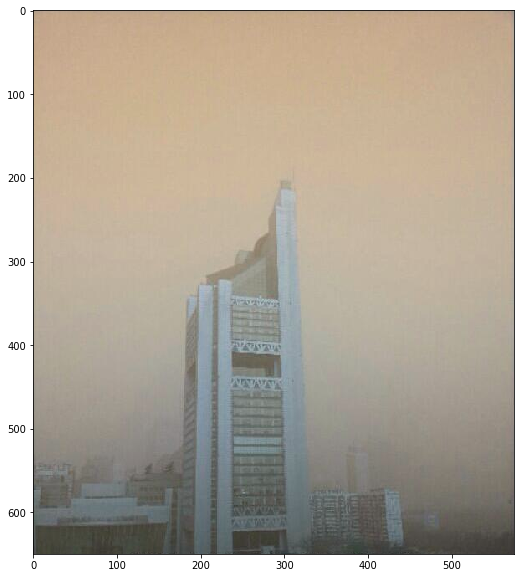

In [3]:
from __future__ import division, absolute_import, print_function
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='0'
import cv2
import numpy as np
import re
import time
import tensorflow as tf
import tensorflow.contrib.slim as slim
import scipy.misc
import matplotlib.pyplot as plt
from skimage import color
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]

from monodepth_model import *
from monodepth_dataloader import *
from average_gradients import *

img_b = cv2.imread('2014_04_01_0700.jpg')
img_sh = cv2.imread('201412311145.jpg')
plt.imshow(img_b[:650, :])

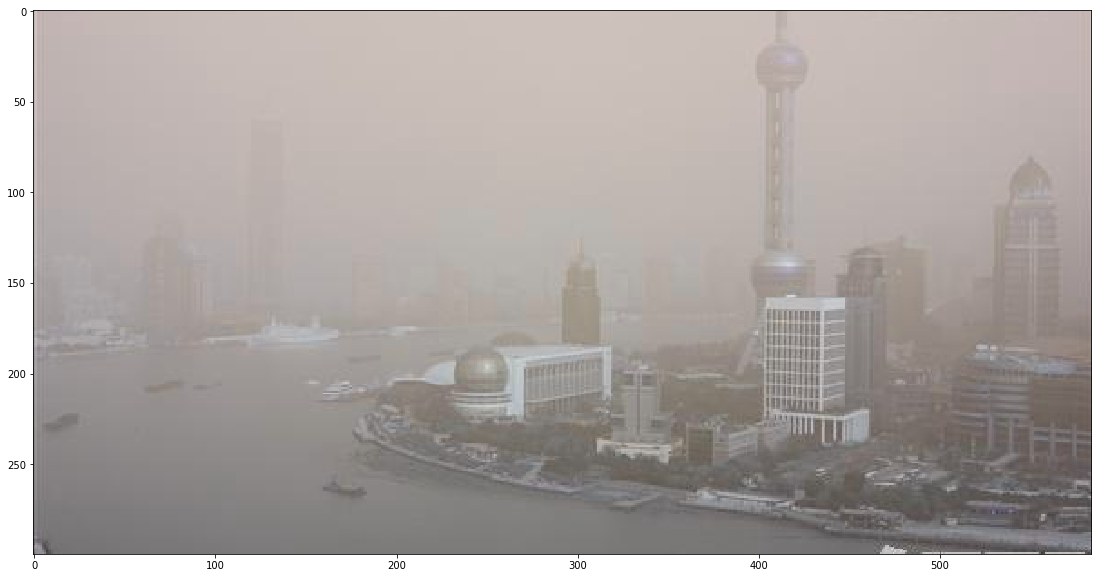

In [4]:
plt.imshow(img_sh[50:350, :])

In [5]:
import pandas as pd

data = pd.read_csv('../single_data.csv')
data.head()

,filename,datetime,dt_round,dt_round_2,ppm
0,Shanghai1/201407241115,201407241115,2014-07-24 11:15:00,2014-07-24 11:00:00,21.0
1,Shanghai1/201407271015,201407271015,2014-07-27 10:15:00,2014-07-27 10:00:00,49.0
2,Shanghai1/201407121315,201407121315,2014-07-12 13:15:00,2014-07-12 13:00:00,63.0
3,Shanghai1/201406171145,201406171145,2014-06-17 11:45:00,2014-06-17 12:00:00,35.0
4,Shanghai1/201407191415,201407191415,2014-07-19 14:15:00,2014-07-19 14:00:00,23.0


In [23]:
class Channel_value:
    val = -1.0
    intensity = -1.0

def find_intensity_of_atmospheric_light(img, gray):
    top_num = int(img.shape[0] * img.shape[1] * 0.001)
    toplist = [Channel_value()] * top_num
    dark_channel = find_dark_channel(img)

    for y in range(img.shape[0]):
        for x in range(img.shape[1]):
            val = img.item(y, x, dark_channel)
            intensity = gray.item(y, x)
            for t in toplist:
                if t.val < val or (t.val == val and t.intensity < intensity):
                    t.val = val
                    t.intensity = intensity
                    break

    max_channel = Channel_value()
    for t in toplist:
        if t.intensity > max_channel.intensity:
            max_channel = t

    return max_channel.intensity

def find_dark_channel(img):
    return np.unravel_index(np.argmin(img), img.shape)[2]

def stats_haze(img, light_intensity, windowSize, t0, w):
    size = (img.shape[0], img.shape[1])
    outimg = np.zeros(size, img.dtype)

    for y in range(size[0]):
        for x in range(size[1]):
            x_low = max(x-(windowSize//2), 0)
            y_low = max(y-(windowSize//2), 0)
            x_high = min(x+(windowSize//2), size[1])
            y_high = min(y+(windowSize//2), size[0])
            sliceimg = img[y_low:y_high, x_low:x_high]
            dark_channel = find_dark_channel(sliceimg)
            t = 1.0 - (w * img.item(y, x, dark_channel) / light_intensity)
            outimg.itemset((y,x), t)
            #outimg.itemset((y,x), max(t,t0)*255)
    
    img_arr = np.ravel(outimg)
    
    per75 = np.percentile(img_arr,75)
    per50 = np.percentile(img_arr,50)
    permax = np.max(img_arr)
    per90 = np.percentile(img_arr,90)
    permean = np.average(img_arr)

    return per50,per75,per90,permean,permax

In [24]:
from scipy.stats import spearmanr

pm = []
per50 = []
per75 = []
per90 = []
permean = []
permax = []

for index, row in data.iterrows():
    city = row['filename'][0]
    filename = '../'+row['filename']+'.jpg'
    if city == "B":
        img = cv2.imread(filename)[:650, :]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        light_intensity = find_intensity_of_atmospheric_light(img, gray)
        w = 0.9
        t0 = 0.01
        a,b,c,d,e = stats_haze(img, light_intensity, 20, t0, w)
        per50.append(a)
        per75.append(b)
        per90.append(c)
        permean.append(d)
        permax.append(e)
        pm.append(float(row['ppm']))
    else:
        img = cv2.imread(filename)[50:350, :]
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        light_intensity = find_intensity_of_atmospheric_light(img, gray)
        w = 0.9
        t0 = 0.01
        a,b,c,d,e = stats_haze(img, light_intensity, 20, t0, w)
        per50.append(a)
        per75.append(b)
        per90.append(c)
        permean.append(d)
        permax.append(e)
        pm.append(float(row['ppm']))

print(spearmanr(pm,per50))
print(spearmanr(pm,per75))
print(spearmanr(pm,per90))
print(spearmanr(pm,permean))
print(spearmanr(pm,permax))

SpearmanrResult(correlation=-0.5140136057695273, pvalue=3.5294445110318717e-23)
SpearmanrResult(correlation=-0.5642821587372082, pvalue=1.4929683684312078e-28)
SpearmanrResult(correlation=-0.5414356239208276, pvalue=5.350496641148381e-26)
SpearmanrResult(correlation=-0.5426362835466154, pvalue=3.971720460990906e-26)
SpearmanrResult(correlation=-0.666031900883825, pvalue=9.078320718106558e-43)


In [25]:
from scipy.stats import pearsonr

print(pearsonr(pm,per50))
print(pearsonr(pm,per75))
print(pearsonr(pm,per90))
print(pearsonr(pm,permean))
print(pearsonr(pm,permax))

(-0.4683372852315315, 5.167559227033611e-19)
(-0.5090729796267576, 1.069101179231113e-22)
(-0.5439057173942811, 2.8945700162602144e-26)
(-0.4867135506925048, 1.2944230616290461e-20)
(-0.7066670066783413, 3.707701411351175e-50)


In [6]:
def post_process_disparity(disp):
    _, h, w = disp.shape
    l_disp = disp[0,:,:]
    r_disp = np.fliplr(disp[1,:,:])
    m_disp = 0.5 * (l_disp + r_disp)
    l, _ = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
    l_mask = 1.0 - np.clip(20 * (l - 0.05), 0, 1)
    r_mask = np.fliplr(l_mask)
    return r_mask * l_disp + l_mask * r_disp + (1.0 - l_mask - r_mask) * m_disp

def test_simple(params,image_path,checkpoint_path,city):

    left  = tf.placeholder(tf.float32, [2, 256, 256, 3])
    model = MonodepthModel(params, "test", left, None)

    input_image = scipy.misc.imread(image_path, mode="RGB")
    
    if city == "B":
        input_image = input_image[:650, :]
    else:
        input_image = input_image[50:350, :]
        
    original_height, original_width, num_channels = input_image.shape
    input_image = scipy.misc.imresize(input_image, [256, 256], interp='lanczos')
    input_image = input_image.astype(np.float32) / 255
    input_images = np.stack((input_image, np.fliplr(input_image)), 0)

    # SESSION
    config = tf.ConfigProto(allow_soft_placement=True)
    sess = tf.Session(config=config)

    # SAVER
    train_saver = tf.train.Saver()

    # INIT
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    coordinator = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(sess=sess, coord=coordinator)

    # RESTORE
    restore_path = checkpoint_path #.split(".")[0]
    train_saver.restore(sess, restore_path)

    disp = sess.run(model.disp_left_est[0], feed_dict={left: input_images})
    disp_pp = post_process_disparity(disp.squeeze()).astype(np.float32)

    #output_directory = os.path.dirname(image_path)
    #output_name = os.path.splitext(os.path.basename(image_path))[0]

    #np.save(os.path.join(output_directory, "{}_disp.npy".format(output_name)), disp_pp)
    disp_to_img = scipy.misc.imresize(disp_pp.squeeze(), [original_height, original_width])
    disp_to_img = color.rgb2gray(disp_to_img)
    #plt.imsave(os.path.join(output_directory, "{}_disp.png".format(output_name)), disp_to_img, cmap='plasma')
    return disp_to_img


In [9]:
#tf.app.run()
params = monodepth_parameters(encoder='vgg',height=256,width=256,batch_size=2,num_threads=1,num_epochs=1,do_stereo=False,wrap_mode="border",use_deconv=False,alpha_image_loss=0,disp_gradient_loss_weight=0,lr_loss_weight=0,full_summary=False)
pm = []
per50 = []
per75 = []
per90 = []
permean = []
permax = []

for index, row in data.iterrows():
    city = row['filename'][0]
    filename = '../'+row['filename']+'.jpg'
    if city == 'B':
        depth_map = test_simple(params,filename,'model_city_kitti/model_city2kitti',city)
        print(depth_map.shape)


ValueError: Variable model/encoder/Conv/weights already exists, disallowed. Did you mean to set reuse=True or reuse=tf.AUTO_REUSE in VarScope? Originally defined at:

  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 277, in variable
    aggregation=aggregation)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 182, in func_with_args
    return func(*args, **current_args)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 350, in model_variable
    aggregation=aggregation)
